<a href="https://colab.research.google.com/github/Vidacelinda/tenser-flow-Analysis-of-Alzheimers-MRI-dataset/blob/main/A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset visualization

Mounted at /content/drive


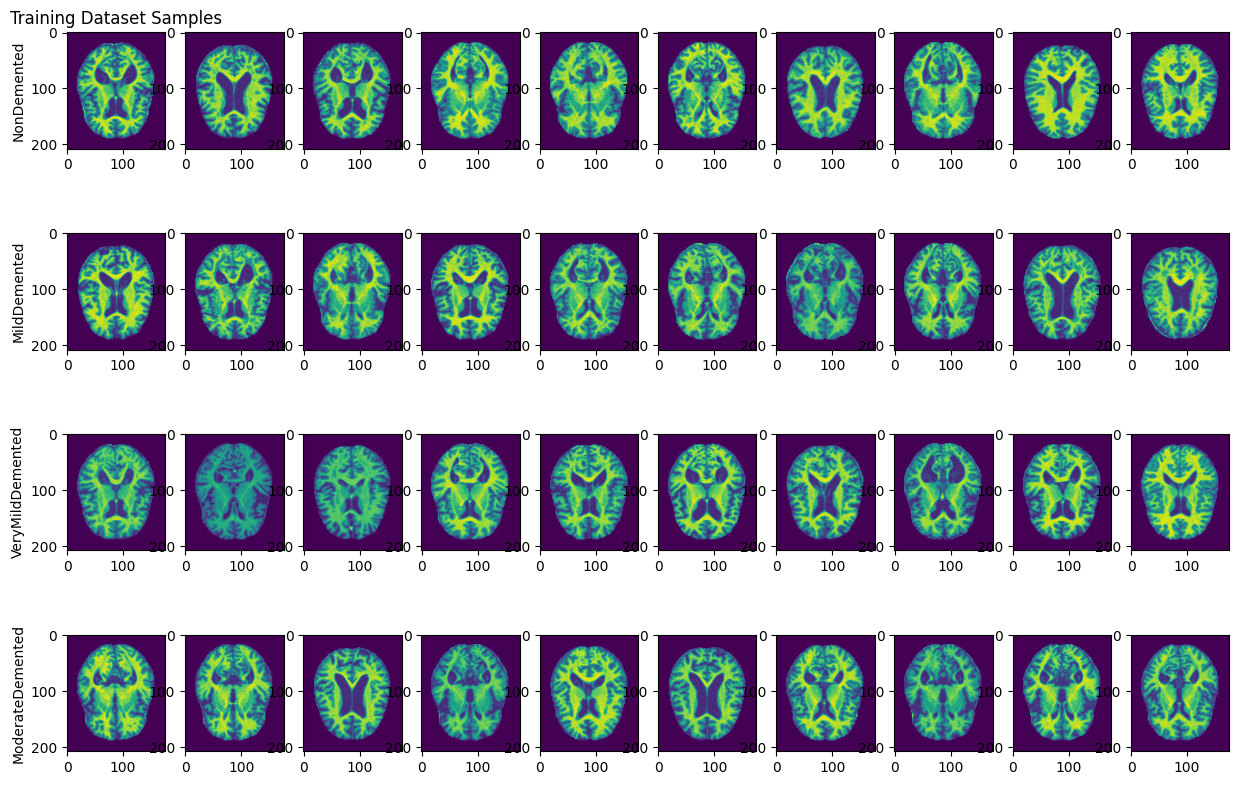

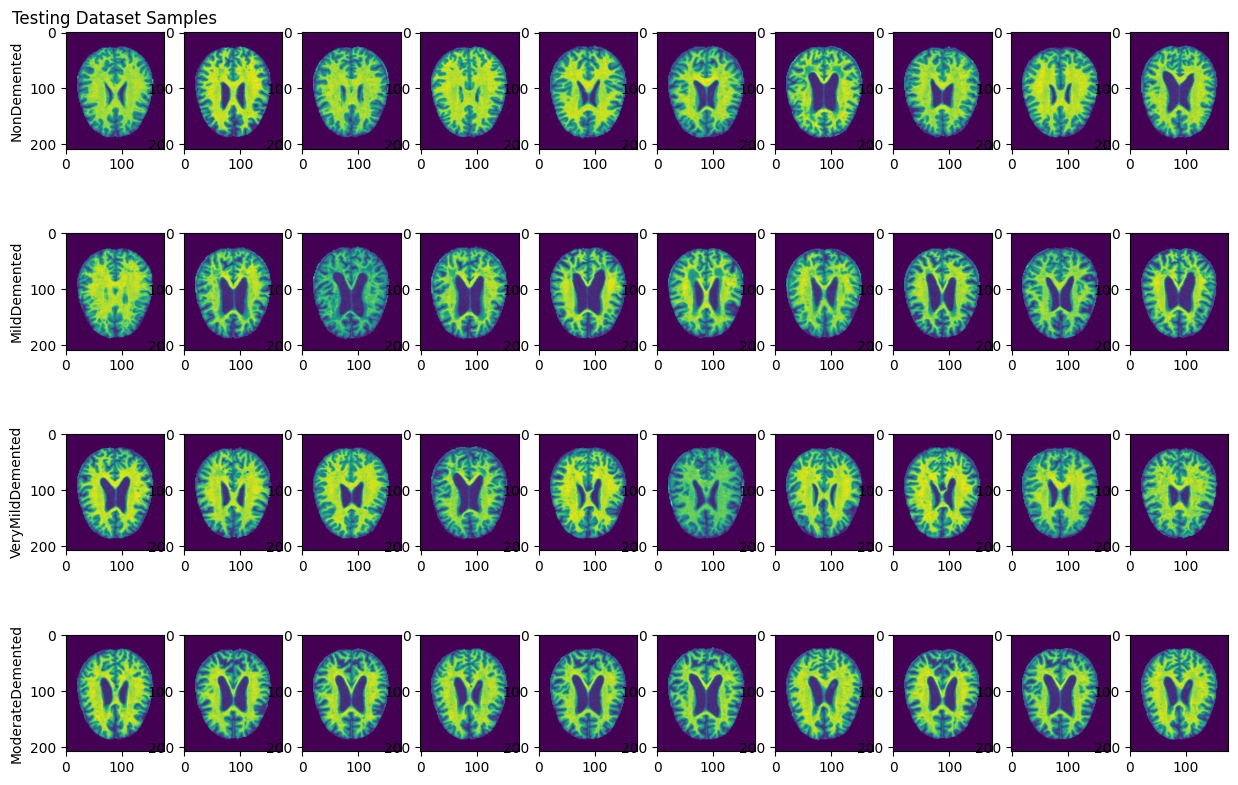

In [1]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

class ImageDisplay:
    def __init__(self, classes, num_images=10):
        self.classes = classes
        self.num_images = num_images

    def display_images_from_folders(self, folders, titles):
        num_folders = len(folders)
        total_num_images = num_folders * self.num_images

        # Increase the width of the figure to create more space
        fig, axes = plt.subplots(len(self.classes), total_num_images, figsize=(15 * total_num_images / 10, 10))

        for f, folder in enumerate(folders):
            for i, class_name in enumerate(self.classes):
                class_path = os.path.join(folder, class_name)
                image_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.lower().endswith(('.jpg'))]
                sample_images = random.sample(image_files, self.num_images)

                for j, img_path in enumerate(sample_images):
                    axes[i, f * self.num_images + j].imshow(Image.open(img_path))
                    axes[i, f * self.num_images + j].axis('on')
                    if j == 0:
                        axes[i, f * self.num_images + j].set_ylabel(class_name)

            axes[0, f * self.num_images].set_title(titles[f])
            #NOT WORKING PORPELY
            # Add a vertical line between training and testing datasets
            if f > 0:
                plt.axvline(x=f * self.num_images - 0.5, color='black', linewidth=1, linestyle='--')

        plt.show()

# Paths to datasets
from google.colab import drive
drive.mount('/content/drive')
train_folder = '/content/drive/MyDrive/ML assignment 4/train/'
test_folder = '/content/drive/MyDrive/ML assignment 4/test/'

# Define classes
classes = ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']

# Create ImageDisplay instance
image_display = ImageDisplay(classes)

# Display images from training and testing datasets
image_display.display_images_from_folders([train_folder], ['Training Dataset Samples'])
image_display.display_images_from_folders([ test_folder], ['Testing Dataset Samples'])


# Transfer Learning model and it's Evaluation accuracy, precision, recall, and F1-score.

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Load all filenames and their corresponding class names
filenames = []
labels = []
for class_name in os.listdir('/content/drive/MyDrive/ML assignment 4/train'):
    class_dir = os.path.join('/content/drive/MyDrive/ML assignment 4/train', class_name)
    if os.path.isdir(class_dir):
        for image in os.listdir(class_dir):
            filenames.append(os.path.join(class_dir, image))
            labels.append(class_name)

# Split the data into training and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42
)

# Create a data generator for the training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Use the DataFrameIterator method of the ImageDataGenerator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_filenames, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load a pre-trained tl_model
base_tl_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained tl_model
for layer in base_tl_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_tl_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

tl_model = Model(inputs=base_tl_model.input, outputs=predictions)

# Compile the tl_model
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the tl_model
tl_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate the tl_model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/ML assignment 4/test', target_size=(224, 224))

# Predictions on the test set
y_true = test_generator.classes
y_pred_prob = tl_model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=-1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Found 4103 validated image filenames belonging to 4 classes.
Found 1026 validated image filenames belonging to 4 classes.
Epoch 1/10
129/129 [==============================] - 24s 147ms/step - loss: 1.1134 - accuracy: 0.4736 - val_loss: 1.1507 - val_accuracy: 0.4776
Epoch 2/10
129/129 [==============================] - 18s 139ms/step - loss: 1.0087 - accuracy: 0.5079 - val_loss: 1.0210 - val_accuracy: 0.5078
Epoch 3/10
129/129 [==============================] - 18s 139ms/step - loss: 1.0163 - accuracy: 0.5026 - val_loss: 1.0218 - val_accuracy: 0.4747
Epoch 4/10
129/129 [==============================] - 18s 139ms/step - loss: 0.9777 - accuracy: 0.5196 - val_loss: 0.9928 - val_accuracy: 0.4815
Epoch 5/10
129/129 [==============================] - 18s 138ms/step - loss: 0.9768 - accuracy: 0.5284 - val_loss: 1.0558 - val_accuracy: 0.4932
Epoch 6/10
129/129 [==============================] - 18s 142ms/step - loss: 0.9605 - accuracy: 0.5289 - val_loss: 1.0058 - val_accuracy: 0.5010
Epoch 7/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DNN ML Model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import os

# Parameters
image_size = (128, 128)
batch_size = 32
num_classes = 4  # Mild Demented, Moderate Demented, Non Demented, Very Mild Demented
epochs = 10

# Load dataset function
def load_data(directory):
    data = []
    labels = []
    for label, category in enumerate(['NonDemented', 'MildDemented', 'VeryMildDemented','ModerateDemented']):
        path = os.path.join(directory, category)
        for image_file in os.listdir(path):
            image_path = os.path.join(path, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image = tf.keras.preprocessing.image.img_to_array(image)
            data.append(image)
            labels.append(label)
    return np.array(data, dtype="float32") / 255.0, np.array(labels)

# Load the training and testing data
from google.colab import drive
drive.mount('/content/drive')
train_data, train_labels = load_data('/content/drive/MyDrive/ML assignment 4/train')  # Replace with your training dataset path
test_data, test_labels = load_data('/content/drive/MyDrive/ML assignment 4/test')  # Replace with your testing dataset path

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

# Build the dnn_model
dnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the dnn_model
dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the dnn_model
dnn_model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the dnn_model
dnn_test_loss, dnn_test_accuracy = dnn_model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {dnn_test_accuracy*100:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
129/129 [==============================] - 5s 26ms/step - loss: 0.9128 - accuracy: 0.6208 - val_loss: 1.5556 - val_accuracy: 0.0156
Epoch 2/10
129/129 [==============================] - 3s 21ms/step - loss: 0.7084 - accuracy: 0.6861 - val_loss: 1.7947 - val_accuracy: 0.0166
Epoch 3/10
129/129 [==============================] - 3s 21ms/step - loss: 0.5341 - accuracy: 0.7724 - val_loss: 1.5104 - val_accuracy: 0.3138
Epoch 4/10
129/129 [==============================] - 2s 18ms/step - loss: 0.3851 - accuracy: 0.8460 - val_loss: 1.5015 - val_accuracy: 0.4220
Epoch 5/10
129/129 [==============================] - 2s 18ms/step - loss: 0.2695 - accuracy: 0.8986 - val_loss: 1.5384 - val_accuracy: 0.4639
Epoch 6/10
129/129 [==============================] - 2s 18ms/step - loss: 0.1983 - accuracy: 0.9276 - val_loss: 0.9267 - val_accuracy: 0.8499
Epoch 7/10
12

# DNN model Evaluation accuracy, precision, recall, and F1-score.

In [8]:
# Predictions on the test set
y_true = np.argmax(test_labels, axis=1)
y_pred_prob = dnn_model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {dnn_test_accuracy*100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

40/40 [==============================] - 1s 9ms/step
Test Accuracy: 56.84%
F1 Score: 0.5560

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.45      0.57       640
           1       0.57      0.32      0.41       179
           2       0.47      0.85      0.61       448
           3       0.00      0.00      0.00        12

    accuracy                           0.57      1279
   macro avg       0.46      0.41      0.40      1279
weighted avg       0.64      0.57      0.56      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Student Designed model

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Model configuration
image_width, image_height = 64, 64
batch_size = 32
epochs = 10
num_classes = 4

# Example CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_directory = "/content/drive/MyDrive/ML assignment 4/train"
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Train the model
model.fit(train_generator, validation_data=validation_generator, epochs=epochs)


test_directory = "/content/drive/MyDrive/ML assignment 4/test"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 4105 images belonging to 4 classes.
Found 1024 images belonging to 4 classes.
Epoch 1/10
129/129 [==============================] - 12s 78ms/step - loss: 1.0156 - accuracy: 0.5133 - val_loss: 1.1297 - val_accuracy: 0.3164
Epoch 2/10
129/129 [==============================] - 10s 80ms/step - loss: 0.8982 - accuracy: 0.5747 - val_loss: 1.1248 - val_accuracy: 0.4492
Epoch 3/10
129/129 [==============================] - 10s 76ms/step - loss: 0.8204 - accuracy: 0.6329 - val_loss: 1.1233 - val_accuracy: 0.4619
Epoch 4/10
129/129 [==============================] - 10s 76ms/step - loss: 0.7326 - accuracy: 0.6758 - val_loss: 1.1181 - val_accuracy: 0.4561
Epoch 5/10
129/129 [==============================] - 10s 75ms/step - loss: 0.6330 - accuracy: 0.7259 - val_loss: 1.1508 - val_accuracy: 0.4512
Epoch 6/10
129/129 [==============================] - 10s 77ms/step - loss: 0.5198 - accuracy: 0.7810 - val_loss: 1.1023 - val_accuracy: 0.4980
Epoch 7/10
129/129 [==============================] 

# Student Designed model Evaluation accuracy, precision, recall, and F1-score.

In [6]:
from sklearn.metrics import f1_score, classification_report

# Predictions on the test set
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=-1)
# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

40/40 [==============================] - 2s 54ms/step
Test Accuracy: 65.36%
F1 Score: 0.3955

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.06      0.09       179
           1       0.00      0.00      0.00        12
           2       0.49      0.55      0.52       640
           3       0.35      0.36      0.35       448

    accuracy                           0.41      1279
   macro avg       0.24      0.24      0.24      1279
weighted avg       0.38      0.41      0.40      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Evaluation ,comparason disussion and Conclusion:

### Accuracy:

- Transfer Learning Model: 45.11%
- DNN Model: 56.84%
- Student Model: 65.36%

The student-designed model outperforms both the transfer learning model and the DNN model in terms of accuracy.

### Precision:

- Transfer Learning Model: 0.38 weighted avg
- DNN Model: 0.64 weighted avg
- Student Model: 0.38 weighted avg

The DNN model achieves the highest precision among the three models.

### Recall:

- Transfer Learning Model: 0.45 weighted avg
- DNN Model: 0.57 weighted avg
- Student Model: 0.41 weighted avg

The DNN model has the highest recall, indicating its ability to correctly identify positive instances.

### F1 Score:

- Transfer Learning Model: 0.41 weighted avg
- DNN Model: 0.56 weighted avg
- Student Model: 0.40 weighted avg

The DNN model achieves the highest F1 score, considering both precision and recall.

## Analysis of Strengths and Weaknesses:

### Transfer Learning Model:

**Strengths:**
- Utilizes pre-trained features from a deep neural network.
- Can capture complex patterns and features.

**Weaknesses:**
- Limited by the pre-trained model's architecture.
- May struggle with domain-specific features not present in the pre-training dataset.

### DNN Model:

**Strengths:**
- Achieves high precision and recall.

**Weaknesses:**
- May require more data for optimal performance.
- Longer training time compared to transfer learning.

### Student-Designed Model:

**Strengths:**
- Highest accuracy among the models.
- Balances precision and recall.

**Weaknesses:**
- May not generalize well to diverse datasets.
- Performance may vary based on the quality and quantity of training data.

## Conclusion:

The student-designed model outperforms the other models in accuracy, making it a promising choice for Alzheimer's disease stage prediction.
The DNN model shows strengths in precision and recall, making it suitable for tasks where a balance between false positives and false negatives is crucial.
The transfer learning model, while leveraging pre-trained features, struggles to match the performance of the other models in this specific task.

## Recommendations:

For high accuracy, consider deploying the student-designed model.

If precision and recall are equally important, the DNN model may be a suitable choice.

Further fine-tuning and experimentation with hyperparameters could potentially improve the models' performances.

Explore the possibility of ensemble methods to combine the strengths of different models.

## Future Work:

Collect additional data to enhance the generalizability of the models.Investigate model interpretability to gain insights into the features influencing predictions.Explore advanced transfer learning techniques or alternative pre-trained models.
